In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import numpy as np
import tensorflow as tf
from dsn.util.systems import V1Circuit
from dsn.train_dsn import train_dsn
from dsn.util.plot_util import assess_constraints, pairplot
from operator import itemgetter
import seaborn as sns
import pandas as pd
import warnings
import scipy
import time
warnings.filterwarnings("ignore")
import os

os.chdir('../../')

In [49]:
# set fixed params

"""
base_I = 0.0
run_I = 1.0
fixed_params = {'b_E':base_I, \
                'b_P':base_I, \
                'b_S':base_I, \
                'b_V':base_I, \
                'h_RUNE':run_I, \
                'h_RUNP':run_I, \
                'h_RUNS':run_I, \
                'h_RUNV':run_I, \
                'h_FFE':0.0, \
                'h_FFP':0.0, \
                'h_LATE':0.0, \
                'h_LATP':0.0, \
                'h_LATS':0.0, \
                'h_LATV':0.0, \
                'n':2.0, \
                's_0':30}"""

fixed_params = {'h_FFE':0.0, \
                'h_FFP':0.0, \
                'h_LATE':0.0, \
                'h_LATP':0.0, \
                'h_LATS':0.0, \
                'h_LATV':0.0, \
                'n':2.0, \
                's_0':30}

behavior_type = "difference"

c_vals=np.array([1.0])
s_vals=np.array([5])
r_vals=np.array([0.0, 1.0])

behavior = {'type':behavior_type, \
            'c_vals':c_vals, \
            's_vals':s_vals, \
            'r_vals':r_vals}

# set model options
model_opts = {"g_FF": "c", "g_LAT": "square", "g_RUN": "r"}
T = 200
dt = 0.05
init_conds = np.expand_dims(np.array([1.0, 1.1, 1.2, 1.3]), 1)

system = V1Circuit(fixed_params, behavior, model_opts, T, dt, init_conds)

print(system.z_labels)

['$W_{EE}$', '$W_{PE}$', '$W_{SE}$', '$W_{VE}$', '$W_{EP}$', '$W_{PP}$', '$W_{VP}$', '$W_{ES}$', '$W_{PS}$', '$W_{VS}$', '$W_{SV}$', '$b_{E}$', '$b_{P}$', '$b_{S}$', '$b_{V}$', '$h_{RUN,E}$', '$h_{RUN,P}$', '$h_{RUN,S}$', '$h_{RUN,V}$', '$\\tau$']


In [50]:
M = 200
taus = [0.2]

num_taus = len(taus)

max_I = 0.8
base_I = np.random.uniform(0.0, max_I, (M,))
b_E = base_I
b_P = base_I
b_S = base_I
b_V = base_I

run_I = base_I + np.random.uniform(0.05, 0.5, (M,))
h_RUNE = run_I
h_RUNP = run_I
h_RUNS = run_I
h_RUNV = run_I

max_W = 5.0
max_WE = 2.0
# column 1
W_E = np.random.uniform(0.0, max_W, (M,))
"""W_EE = W_E
W_PE = W_E
W_SE = W_E
W_VE = W_E"""
W_EE = np.random.uniform(0.0, max_WE, (M,))
W_PE = np.random.uniform(0.0, max_WE, (M,))
W_SE = np.random.uniform(0.0, max_WE, (M,))
W_VE = np.random.uniform(0.0, max_WE, (M,))

# column 2
W_EP = np.random.uniform(0.0, max_W, (M,))
W_PP = np.random.uniform(0.0, max_W, (M,))
W_VP = np.random.uniform(0.0, max_W, (M,))

# column 3
W_ES = np.random.uniform(0.0, max_W, (M,))
W_PS = np.random.uniform(0.0, max_W, (M,))
W_VS = np.random.uniform(0.0, max_W, (M,))

# column 4
W_SV = np.random.uniform(0.0, max_W, (M,))

tau = np.zeros((M,))

_Z = np.stack((W_EE, W_PE, W_SE, W_VE, W_EP, W_PP, W_VP, W_ES, W_PS, W_VS, W_SV, \
               b_E, b_P, b_S, b_V, h_RUNE, h_RUNP, h_RUNS, h_RUNP, tau), axis=1)
_Z = np.expand_dims(_Z, 0)


In [51]:
num_params = system.D;
Z = tf.placeholder(dtype=tf.float64, shape=(1, None, num_params));

sess = tf.Session()
r_t = system.simulate(Z)

In [52]:
_r_ts = []
for i in range(num_taus):
    _tau = taus[i]
    _Z[0,:,-1] = _tau
    _r_t = sess.run(r_t, {Z:_Z});
    _r_ts.append(_r_t)


In [54]:
print(_r_t.shape)

(200, 2, 200, 4, 1)


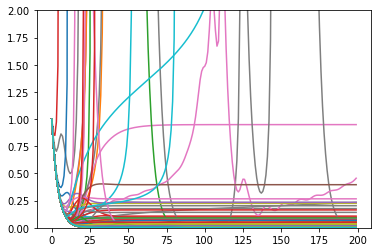

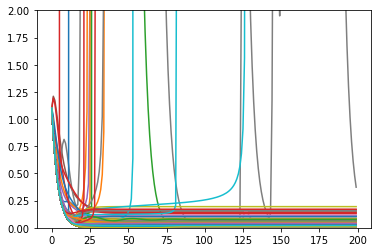

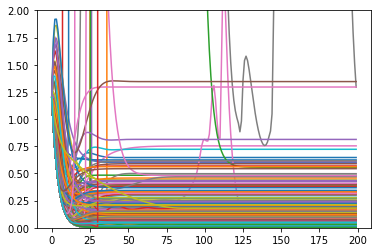

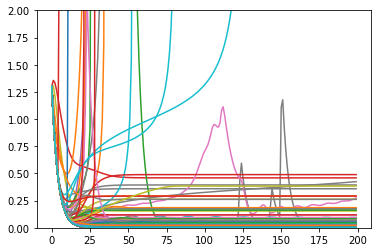

In [61]:
for i in range(4):
    plt.figure()
    lines = plt.plot(_r_t[:,0,:,i,0])
    plt.ylim([0, 2])
    plt.show()

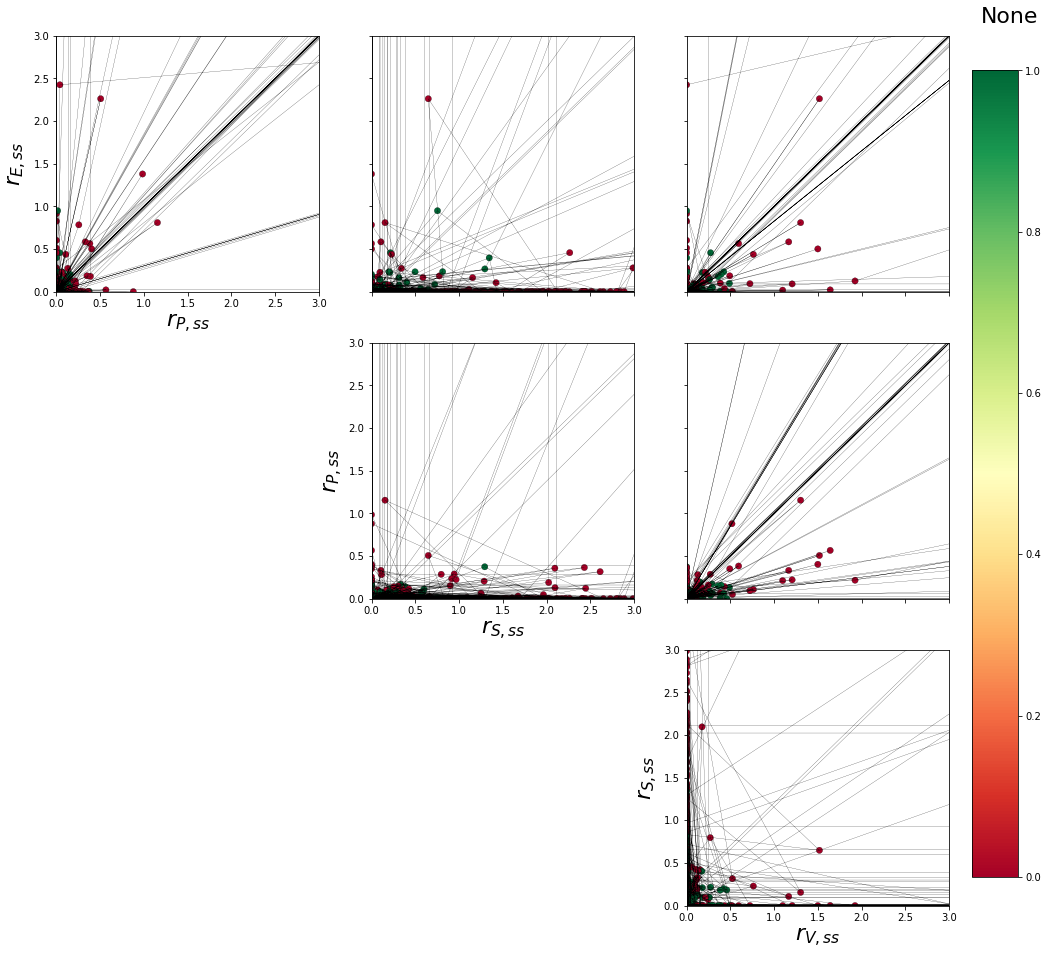

In [53]:
C = _r_t.shape[1]
r_SS = np.reshape(_r_t[-1,:,:,:, 0], (C*M, 4))
#c = np.concatenate((np.ones((M,)), np.zeros((M,))), axis=0)
_M = M
c = np.concatenate((np.ones((_M,)), np.zeros((_M,))), axis=0)
max_val = 3.0
labels = [r'$r_{E,ss}$', r'$r_{P,ss}$', r'$r_{S,ss}$', r'$r_{V,ss}$']

figs = pairplot(r_SS[:2*_M,:], range(4), labels, origin=False,
                c=c, c_label=None, cmap='RdYlGn', ss=True, xlims=[0,max_val],
                ylims=[0,max_val], ticks=None, fontsize=22, figsize=(16, 16))